# Imports

In [131]:
import tensorflow as tf
import sklearn.cluster as cluster
import sklearn.manifold as manifold
import plotly.offline as plotly
import plotly.graph_objs as go
from matplotlib.pyplot import imshow
import matplotlib

from learning_lib.nn.cnn import CNN
from learning_lib.nn.autoencoder import convert_to_autoencoder

from datacollection.utils import generateFilePathStr

import h5py
import numpy as np
import pandas as pd
import random
import itertools
from PIL import Image

In [132]:
%matplotlib inline

In [133]:
plotly.init_notebook_mode(connected=True)
matplotlib.rcParams['figure.figsize'] = [16, 16]

# Load Model

In [2]:
LC = [
    {
        'layer_type': 'conv',
        'filter_size': [6, 6, 10, 64],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,
        'stride_size': [1, 2, 2, 1],
        'activation': tf.tanh,
        'output_size': [62, 62, 64]
    },
    {
        'layer_type': 'conv',
        'filter_size': [6, 6, 64, 64],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,
        'stride_size': [1, 1, 1, 1],
        'activation': tf.tanh,
        'output_size': [57, 57, 64]
    },
    {
        'layer_type': 'conv',
        'filter_size': [4, 4, 64, 64],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,
        'stride_size': [1, 1, 1, 1],
        'activation': tf.tanh,
        'output_size': [54, 54, 64]
    },
    {
        'layer_type': 'conv',
        'filter_size': [4, 4, 64, 64],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,
        'stride_size': [1, 1, 1, 1],
        'activation': tf.tanh,
        'output_size': [51, 51, 64]
    },
    {
        'layer_type': 'conv_transpose',
        'filter_size': [4, 4, 64, 64],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,
        'stride_size': [1, 1, 1, 1],
        'activation': tf.tanh,
        'output_size': [200, 54, 54, 64]
    },
    {
        'layer_type': 'conv_transpose',
        'filter_size': [4, 4, 64, 64],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,
        'stride_size': [1, 1, 1, 1],
        'activation': tf.tanh,
        'output_size': [200, 57, 57, 64]
    },
    {
    'init_filter_stddev': 0.01,
        'layer_type': 'conv_transpose',
        'filter_size': [6, 6, 64, 64],
        'init_filter_mean': 0.0,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,
        'stride_size': [1, 1, 1, 1],
        'activation': tf.tanh,
        'output_size': [200, 62, 62, 64]
    },
    {
        'layer_type': 'conv_transpose',
        'filter_size': [6, 6, 10, 64],
        'init_filter_mean': 0.0,
        'init_filter_stddev': 0.01,
        'init_bias_mean': 0.0,
        'init_bias_stddev': 0.01,
        'stride_size': [1, 2, 2, 1],
        'activation': tf.tanh,
        'output_size': [200, 128, 128, 10]
    }
]

In [3]:
cnn = CNN(LC)
cnn.init_session()
saver = tf.train.Saver()
saver.restore(
    cnn.session,
    tf.train.latest_checkpoint('/home/fwang/earth_data/datasets/cloud-segmentation/autoencoder/models')
)

In [16]:
cnn = convert_to_autoencoder(cnn, 3)

# Inspect Model

In [8]:
def get_dataset(images, n, h5F):
    scene_list = []
    x_list = []
    y_list = []
    dataset = np.empty((
        len(images) * n,
        len(bands) * grid_size ** 2
    ))

    j = 0
    for sceneid in images:
        print("Generating sample for {}".format(sceneid))
        for _ in range(n):
            subimage = np.array(0)
            while (subimage == 0).any():
                dim = h5F[sceneid][bands[0]].shape
                subimage = np.empty((len(bands), grid_size, grid_size))
                x = random.randint(grid_size / 2, dim[0] - grid_size / 2 - 1)
                y = random.randint(grid_size / 2, dim[1] - grid_size / 2 - 1)

                for i, b in enumerate(bands):
                    subimage[i] = h5F[sceneid][b][
                        int(x - grid_size / 2) : int(x + grid_size / 2),
                        int(y - grid_size / 2) : int(y + grid_size / 2)
                    ]

            dataset[j] = subimage.flatten()
            scene_list.append(sceneid)
            x_list.append(x)
            y_list.append(y)
            j += 1
    
#     dataset = dataset.transpose((0, 2, 3, 1))
    reference_df = pd.DataFrame({
        'sceneid': scene_list,
        'x': x_list,
        'y': y_list
    })
    
    return dataset, reference_df

In [110]:
images = ['LC80070522015173LGN00']
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9', 'B10', 'B11']
grid_size = 128

with h5py.File(generateFilePathStr(kind='database'), 'r') as h5F:
    data, reference_df = get_dataset(images, 1000, h5F)
    
data = data.reshape((1000, len(bands), grid_size, grid_size)).transpose((0, 2, 3, 1)).astype('float32')
data = data / (2.0 ** 16) - 0.5

Generating sample for LC80070522015173LGN00


In [ ]:
response = cnn.predict(in_vector=data)
response = (((response + 0.5) * (response > -0.5).astype('float')) * (2.0 ** 8)).astype('uint8')

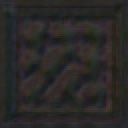

In [81]:
Image.fromarray(response[13,:,:,2:5])

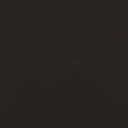

In [80]:
Image.fromarray(((data[13,:,:,2:5] + 0.5) * (2.0 ** 8)).astype('uint8'))

In [112]:
response = cnn.encode(in_vector=data)

## TSNE

In [116]:
tsne = manifold.TSNE()
embedded = tsne.fit_transform(response.reshape((1000, -1)))

In [117]:
plotly.iplot([
    go.Scatter(
        x=embedded[:,0],
        y=embedded[:,1],
        mode='markers'
    )
])

## Image Plots

In [119]:
def color_image(sceneid, stride, grouping_function, flatten=True):
    image = np.array(Image.open(generateFilePathStr(sceneid, 'preproc', 'visible')))
    mask = np.zeros((image.shape[0] // stride, image.shape[1] // stride, 3), 'uint8')
    stride *= 2
    dim = (image.shape[0] * 2, image.shape[1] * 2)
    
    x_iterator = range(grid_size // 2, dim[0] - grid_size // 2, stride)
    y_iterator = range(grid_size // 2, dim[1] - grid_size // 2, stride)

    with h5py.File(generateFilePathStr(kind='database'), 'r') as h5F:

        batch_size = len(y_iterator)
        
        for i in x_iterator:
            dp = np.empty((batch_size, len(bands), grid_size, grid_size))
            
            for (j_index, j), (band_index, band) in itertools.product(
                enumerate(y_iterator),
                enumerate(bands)
            ):
                dp[j_index, band_index] = h5F[sceneid][band][
                    i - grid_size // 2 : i + grid_size // 2,
                    j - grid_size // 2 : j + grid_size // 2
                ]
                
#             dp = dp.transpose((0, 2, 3, 1))
            if flatten:
                dp = dp.reshape((batch_size, -1))
                
            groups = grouping_function(dp)
            
            mask[i // stride, np.array(y_iterator)[groups == 0] // stride, 0] = 255
            mask[i // stride, np.array(y_iterator)[groups == 1] // stride, 1]= 255
            mask[i // stride, np.array(y_iterator)[groups == 2] // stride, 2] = 255
            
    return mask

In [136]:
%%time
km = cluster.KMeans(3)
km.fit(response.reshape((1000, -1)))

def test_function(dp):
    dp = dp / (2.0 ** 16) - 0.5
    dp = dp.reshape((-1, len(bands), grid_size, grid_size))
    transformed_data = cnn.encode(dp.transpose((0, 2, 3, 1)))
    return km.predict(transformed_data.reshape((transformed_data.shape[0], -1)))
    
image = color_image('LC80070522015173LGN00', 32, test_function)

CPU times: user 2min 57s, sys: 1min 2s, total: 3min 59s
Wall time: 3min 41s


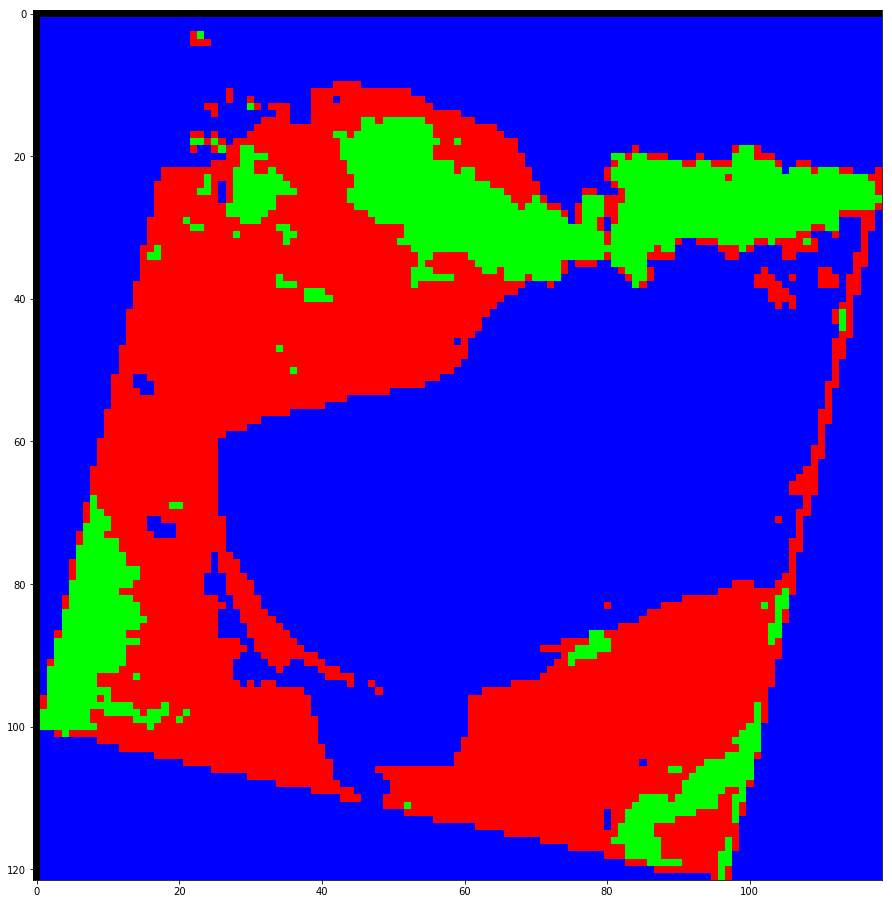

In [137]:
imshow(np.asarray(image))

In [138]:
%%time
km = cluster.KMeans(3)
km.fit(data.reshape((1000, -1)))

def test_function(dp):
    dp = dp / (2.0 ** 16) - 0.5
    return km.predict(dp)
    
dp = color_image('LC80070522015173LGN00', 32, test_function)

CPU times: user 2min 27s, sys: 45.1 s, total: 3min 12s
Wall time: 2min 55s


In [129]:
imshow(np.asarray(dp))

NameError: name 'dp' is not defined